# Sentiment Classification

Instead of using an unsupervised method like VADER for sentiment analysis, I will create a model that will try to predict the sentiment of a review with supervised learning methods.

In [55]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from ast import literal_eval

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score

from sklearn.pipeline import Pipeline

import spacy
import contractions
import re

from gensim.models import Word2Vec

from sklearn.manifold import TSNE

In [27]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [2]:
#data = pd.read_csv('data/processed_reviews.csv', converters = {'cleaned_text': literal_eval})

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133546 entries, 0 to 133545
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   reviews         133546 non-null  object
 1   sentiment       133546 non-null  int64 
 2   cleaned_text    133546 non-null  object
 3   dominant_topic  133546 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 4.1+ MB


In [5]:
data.head()

,reviews,sentiment,cleaned_text,dominant_topic,cleaned_text_sent
0,"Get the SportaPros instead. They look better,...",1,"['instead', 'look', 'well', 'wear', 'street', ...",4,"[sportapros, instead, look, well, wear, street..."
1,I've been looking for a lighter alternative to...,1,"['look', 'light', 'alternative', 'absolutely',...",2,"[look, light, alternative, absolutely, perfect..."
2,The finest headphones available. You can spend...,1,"['fine', 'headphone', 'available', 'spend', 'v...",2,"[fine, headphone, available, spend, vast, amou..."
3,3rd pair of these I've purchased. My wife has...,1,"['pair', 'purchase', 'wife', 'pair', 'pair', '...",3,"[rd, pair, purchase, wife, pair, pair, glove, ..."
4,My old Koss Porta Pros finally got beat to dea...,1,"['old', 'finally', 'get', 'beat', 'death', 'ye...",4,"[old, koss, porta, pros, finally, get, beat, d..."


In [6]:
data.sentiment.value_counts(normalize = True)

1    0.766582
0    0.233418
Name: sentiment, dtype: float64

## Text Cleaning for sentiment analysis

I will need to modify the text cleaning process for sentiment analysis. Negation words such as not and no are usually removed by standard stop word lists. These negations may not have made a big difference for topic modeling, but they can change the sentiment of a statement depending on if they are removed or not. For example the phrase "Not great, do not buy" is a negative statement. But after removal of standard stop words the statment will be "great buy", which can be seen as positive.

In [106]:
stop_words = spacy.lang.en.stop_words.STOP_WORDS

In [107]:
len(stop_words)

326

In [ ]:
# list for words to remove from stop_words
stop_list = ['cannot', 'not', 'nor', 'no']

In [ ]:
for item in stop_list:
    # Add the word to the set of stop words.
    nlp.Defaults.stop_words.remove(item)
    
    # Set the stop_word tag on the lexeme
    nlp.vocab[item].is_stop = False

In [109]:
len(stop_words)

326

Another step I will be adding is to expand conractions. This will allow me to preserve 'not' tokens. For this i will be using the contractions library that expands contractions with below simple code.

In [111]:
contractions.fix('wont cant dont')

'will not cannot do not'

In [24]:
def clean_text(text):
    # Replace &nbsp; with regular space
    text = text.replace("&nbsp;", " ")
    # Remove HTML tags and attributes
    text = re.sub(r"<[^>]+>", "", text)
    # Remove URLs
    text = re.sub(r"http\S+", "", text)
    # Remove line breaks and extra whitespace
    text = re.sub(r"\s+", " ", text)
    # Expand contractions
    text = contractions.fix(text)
    # Remove numbers and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Convert to lowercase and remove leading/trailing white space
    # Tokenize and lemmatize, keep words with length greater than 1
    doc = nlp(text)
    lemmas = [token.lemma_.lower().strip() for token in doc if not token.is_punct and not token.is_stop and len(token) > 1]
    
    return lemmas

In [110]:
# sample review to test clean function
data.reviews[132512]

"I got these headphones as a xmas for my wife (yeah for me too). I own multiple pairs of corded headphones and one other pair of cheap bluetooth headphones (Kinivo BTH240). My daily go to headphones are a pair of Sennheiser hd 280 pro cans and I have a pair of Audio-Technica ATH-M30 that I use at work.\n\nRatings:\n\nSound: 8/10\n\nThe sound is fairly detailed and well balanced. The bass end is not overpowering nor underwhelming. Midrange is clear and distinct. High end has detail and it is not too tinny. YMMV. I would say, for the headphones I use, the sound reproduction is somewhere between my Audio-Technica ATH-M30 but not quite as good as my Sennheiser hd 280. Which is on par for the price range they are in. Come on people, stop comparing these to headphones that cost 3-5 times as much.\n\nComfort: 10/10\n\nThese fit over my ears well and these may very well be the most comfortable headphones I presently own. Most headphones I wear do not bother me much and these are no exception.\

In [143]:
clean_text(data.reviews[132512])

['get',
 'headphone',
 'xma',
 'wife',
 'yeah',
 'multiple',
 'pair',
 'cord',
 'headphone',
 'pair',
 'cheap',
 'bluetooth',
 'headphone',
 'kinivo',
 'bth',
 'daily',
 'headphone',
 'pair',
 'sennheiser',
 'hd',
 'pro',
 'can',
 'pair',
 'audiotechnica',
 'athm',
 'use',
 'work',
 'ratings',
 'sound',
 'sound',
 'fairly',
 'detailed',
 'balance',
 'bass',
 'end',
 'overpower',
 'underwhelme',
 'midrange',
 'clear',
 'distinct',
 'high',
 'end',
 'detail',
 'tinny',
 'ymmv',
 'headphone',
 'use',
 'sound',
 'reproduction',
 'audiotechnica',
 'athm',
 'good',
 'sennheiser',
 'hd',
 'par',
 'price',
 'range',
 'come',
 'people',
 'stop',
 'compare',
 'headphone',
 'cost',
 'time',
 'comfort',
 'fit',
 'ear',
 'comfortable',
 'headphone',
 'presently',
 'headphone',
 'wear',
 'bother',
 'exception',
 'build',
 'quality',
 'headphone',
 'solid',
 'feel',
 'lot',
 'like',
 'high',
 'end',
 'benz',
 'car',
 'door',
 'time',
 'tell',
 'durable',
 'lot',
 'confidence',
 'noise',
 'cancellatio

In [ ]:
data['cleaned_text_sent'] = data.reviews.apply(lambda x: clean_text(x))

In [ ]:
#data.to_csv('data/cleaned_reviews.csv', index = False)

In [56]:
data = pd.read_csv('data/cleaned_reviews.csv', converters = {'cleaned_text_sent': literal_eval})

## Feature Engineering

Since my features are text data, before I can input into any models I will need to vectorize the text to be represented as numbers. I will test out various vectorizers and classification models to find the best performing model. 

Vectorizers:
* CountVectorizer
* TfidfVectorizer
* Word2Vec
* Pre-trained Glove

Classification Algorithms:
* Logistic Regression
* Naive Bayes
* Random Forest

## Data Preprocessing

Seperating target and features

In [57]:
# Changing sentiment to numerical values
data.replace({'sentiment':{'Negative': 0, 'Positve': 1}}, inplace = True)

TypeError: Cannot compare types 'ndarray(dtype=int64)' and 'str'

In [58]:
data.sentiment.value_counts(normalize = True)

1    0.766582
0    0.233418
Name: sentiment, dtype: float64

In [59]:
X = data.cleaned_text_sent
y = data.sentiment

### Train Test Split

Splitting data to train and test sets with stratify to keep class percentages similar in both.

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    stratify = y,
                                                    random_state = 42)

In [5]:
X_train.shape

(106836,)

In [6]:
X_test.shape

(26710,)

In [7]:
y_train.value_counts(normalize = True)

1    0.766586
0    0.233414
Name: sentiment, dtype: float64

In [8]:
y_test.value_counts(normalize = True)

1    0.766567
0    0.233433
Name: sentiment, dtype: float64

## Baseline Model

For our baseline model I will use logistic regression / countvectorizer and optimize for f1 score due to imbalanced dataset, as this metric will have a good balance of precision and recall.

### Count Vectorizer

Vectorizer used to create a bag of words model. Will create a matrix will all the words avaliable in the documents and the number of times they appear.

In [61]:
def dummy(doc):
    return doc

In [10]:
# Instantiate CountVectorizer with unigrams and bigrams
count_vect = CountVectorizer(ngram_range = (1,2), 
                             stop_words = None, 
                             tokenizer = dummy, 
                             preprocessor = dummy,
                             min_df = 10)

In [219]:
count_vect.fit(X_train)

CountVectorizer(min_df=10, ngram_range=(1, 2),
                preprocessor=<function dummy at 0x000001E74594C430>,
                tokenizer=<function dummy at 0x000001E74594C430>)

In [220]:
# Total vocabulary length
len(count_vect.get_feature_names())

64601

#### Logistic Regression

In [62]:
# instantiate classifier, class weights set to balanced for imbalanced dataset
logr = LogisticRegression(class_weight = 'balanced', 
                          # solver set to saga for larger dataset
                          solver = 'saga', 
                          max_iter = 1000)

In [126]:
# making pipeline for vectorizer and classifier
cv_logr_model = Pipeline([
    ('countvec', count_vect),
    ('logr', logr)
])

Since I am working with an imbalanced dataset and what to treat both classes equally. I will be focusing on macro metrics. I will choose to observed f1_macro, precision_macro and recall_macro scores between different algorithms.

In [142]:
# running cross validation
cv_logr = cross_validate(cv_logr_model, X_train, y_train, cv = 5, 
                         scoring = ['f1_macro', 'precision_macro', 'recall_macro'])

C:\Users\PC\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\PC\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\PC\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\PC\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\PC\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:

In [143]:
# creating dataframe to store results
model_results = pd.DataFrame(columns=['Model', 'mean f1_score', 'std f1_score', 'mean precision', 'mean recall'])

In [144]:
model_results = model_results.append({'Model': 'cv_logr_model',
                      'mean f1_score': round(cv_logr['test_f1_macro'].mean(), 4),
                      'std f1_score': round(cv_logr['test_f1_macro'].std(), 4),
                      'mean precision': round(cv_logr['test_precision_macro'].mean(), 4),
                      'mean recall': round(cv_logr['test_recall_macro'].mean(), 4)}, ignore_index = True)

In [145]:
model_results

,Model,mean f1_score,std f1_score,mean precision,mean recall
0,cv_logr_model,0.8445,0.0026,0.8368,0.8532


C:\Users\PC\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\PC\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\PC\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\PC\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\PC\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:

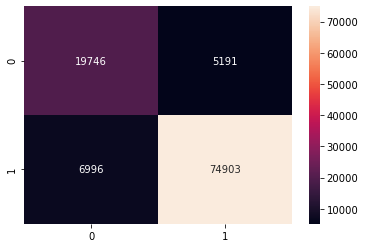

In [17]:
# plotting confusion matrix with cross_val_predict, this method uses vales that matches closer to cross validated scores
cv_logr_hat = cross_val_predict(cv_logr_model, X_train, y_train, cv = 5)
cm = confusion_matrix(y_train, cv_logr_hat)
f = sns.heatmap(cm, annot=True, fmt = 'g')

Decent results for a baseline model. f1 score of 84% was obtained. High scores for precision and recall are also observed. 

#### Naive Bayes

In [146]:
# class_prior set to ratio of target classes to help with class imbalance
mnb = MultinomialNB(class_prior = [0.23, 0.77])

In [147]:
cv_mnb_model = Pipeline([
    ('countvec', count_vect),
    ('mnb', mnb)
])

In [148]:
cv_mnb = cross_validate(cv_mnb_model, X_train, y_train, cv = 5, 
                        scoring = ['precision_macro', 'recall_macro', 'f1_macro'])

model_results = model_results.append({'Model': 'cv_mnb_model',
                      'mean f1_score': round(cv_mnb['test_f1_macro'].mean(), 4),
                      'std f1_score': round(cv_mnb['test_f1_macro'].std(), 4),
                      'mean precision': round(cv_mnb['test_precision_macro'].mean(), 4),
                      'mean recall': round(cv_mnb['test_recall_macro'].mean(), 4)}, ignore_index = True)

model_results

,Model,mean f1_score,std f1_score,mean precision,mean recall
0,cv_logr_model,0.8445,0.0026,0.8368,0.8532
1,cv_mnb_model,0.8318,0.0023,0.8216,0.8441


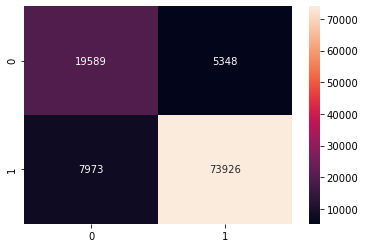

In [23]:
cv_mnb_hat = cross_val_predict(cv_mnb_model, X_train, y_train, cv = 5)
cm = confusion_matrix(y_train, cv_mnb_hat)
f = sns.heatmap(cm, annot=True, fmt = 'g')

Naive Bayes was not able to perform better than baseline. It was able to compute predictions much faster though.

#### Random Forest

In [149]:
rf = RandomForestClassifier(class_weight = 'balanced', random_state=42)

In [150]:
cv_rf_model = Pipeline([
    ('countvec', count_vect),
    ('rf', rf)
])

In [151]:
cv_rf = cross_validate(cv_rf_model, X_train, y_train, cv = 5, 
                       scoring = ['precision_macro', 'recall_macro', 'f1_macro'])

model_results = model_results.append({'Model': 'cv_rf_model',
                      'mean f1_score': round(cv_rf['test_f1_macro'].mean(), 4),
                      'std f1_score': round(cv_rf['test_f1_macro'].std(), 4),
                      'mean precision': round(cv_rf['test_precision_macro'].mean(), 4),
                      'mean recall': round(cv_rf['test_recall_macro'].mean(), 4)}, ignore_index = True)
model_results

,Model,mean f1_score,std f1_score,mean precision,mean recall
0,cv_logr_model,0.8445,0.0026,0.8368,0.8532
1,cv_mnb_model,0.8318,0.0023,0.8216,0.8441
2,cv_rf_model,0.7974,0.0029,0.8771,0.7602


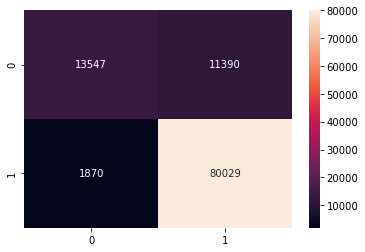

In [28]:
cv_rf_hat = cross_val_predict(cv_rf_model, X_train, y_train, cv = 5)
cm = confusion_matrix(y_train, cv_rf_hat)
f = sns.heatmap(cm, annot=True, fmt = 'g')

Random Forest performed lower than baseline model when comparing f1 score. Precision was observed to be higher than baseline at 88%. 

### TF-IDF

One way to focus on more meaningful terms is to use TF-IDF Vectorizer. TF-IDF scores give more importance to terms that appear frequently in a certain document, but less frequent in all other documents. TF-IDF scores will be lower for words that appear frequently in all documents.

In [63]:
tfidf = TfidfVectorizer(ngram_range = (1,2), 
                             stop_words = None, 
                             tokenizer = dummy, 
                             preprocessor = dummy,
                             min_df = 10)

In [44]:
tfidf.fit(X_train)

C:\Users\PC\anaconda3\envs\learn-env\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


TfidfVectorizer(min_df=10, ngram_range=(1, 2),
                preprocessor=<function dummy at 0x000002213024D700>,
                tokenizer=<function dummy at 0x000002213024D700>)

In [45]:
# Total vocabulary length
len(tfidf.get_feature_names())

64601

Total vocabulary similar to count vectorizer.

#### Logistic Regression

In [64]:
tfidf_logr_model = Pipeline([
    ('tfidfvec', tfidf),
    ('logreg', logr)
])

In [65]:
tfidf_logr = cross_validate(tfidf_logr_model, X_train, y_train, cv = 5, 
                            scoring = ['precision_macro', 'recall_macro', 'f1_macro'])

model_results = model_results.append({'Model': 'tfidf_logr_model',
                      'mean f1_score': round(tfidf_logr['test_f1_macro'].mean(), 4),
                      'std f1_score': round(tfidf_logr['test_f1_macro'].std(), 4),
                      'mean precision': round(tfidf_logr['test_precision_macro'].mean(), 4),
                      'mean recall': round(tfidf_logr['test_recall_macro'].mean(), 4)}, ignore_index = True)
model_results

KeyboardInterrupt: 

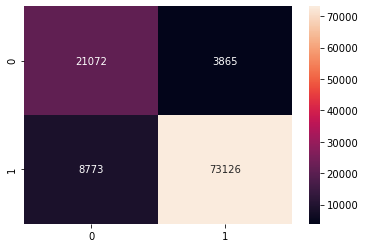

In [35]:
tfidf_logr_hat = cross_val_predict(tfidf_logr_model, X_train, y_train, cv = 5)
cm = confusion_matrix(y_train, tfidf_logr_hat)
f = sns.heatmap(cm, annot=True, fmt = 'g')

TF-IDF vectorizer shows an improvemnt over baseline's countvectorizer, achieving a higher recall score of 87%.

#### Naive Bayes

In [155]:
tfidf_mnb_model = Pipeline([
    ('tfidfvec', tfidf),
    ('mnb', mnb)
])

In [157]:
tfidf_mnb = cross_validate(tfidf_mnb_model, X_train, y_train, cv = 5, 
                           scoring = ['precision_macro', 'recall_macro', 'f1_macro'])

model_results = model_results.append({'Model': 'tfidf_mnb_model',
                      'mean f1_score': round(tfidf_mnb['test_f1_macro'].mean(), 4),
                      'std f1_score': round(tfidf_mnb['test_f1_macro'].std(), 4),
                      'mean precision': round(tfidf_mnb['test_precision_macro'].mean(), 4),
                      'mean recall': round(tfidf_mnb['test_recall_macro'].mean(), 4)}, ignore_index = True)
model_results

,Model,mean f1_score,std f1_score,mean precision,mean recall
0,cv_logr_model,0.8445,0.0026,0.8368,0.8532
1,cv_mnb_model,0.8318,0.0023,0.8216,0.8441
2,cv_rf_model,0.7974,0.0029,0.8771,0.7602
3,tfidf_logr_model,0.8449,0.0037,0.8279,0.8689
4,tfidf_mnb_model,0.7371,0.0018,0.8789,0.6976


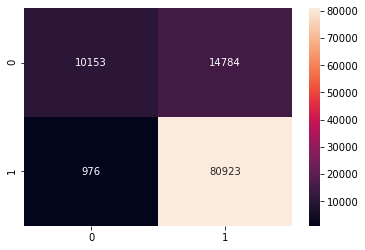

In [39]:
tfidf_mnb_hat = cross_val_predict(tfidf_mnb_model, X_train, y_train, cv = 5)
cm = confusion_matrix(y_train, tfidf_mnb_hat)
f = sns.heatmap(cm, annot=True, fmt = 'g')

TF-IDF with NB performed poorly compared to baseline due to a higher number of false positives found.

#### Random Forest

In [158]:
tfidf_rf_model = Pipeline([
    ('tfidfvec', tfidf),
    ('rf', rf)
])

In [159]:
tfidf_rf = cross_validate(tfidf_rf_model, X_train, y_train, cv = 5, 
                          scoring = ['precision_macro', 'recall_macro', 'f1_macro'])

model_results = model_results.append({'Model': 'tfidf_rf_model',
                      'mean f1_score': round(tfidf_rf['test_f1_macro'].mean(), 4),
                      'std f1_score': round(tfidf_rf['test_f1_macro'].std(), 4),
                      'mean precision': round(tfidf_rf['test_precision_macro'].mean(), 4),
                      'mean recall': round(tfidf_rf['test_recall_macro'].mean(), 4)}, ignore_index = True)
model_results

,Model,mean f1_score,std f1_score,mean precision,mean recall
0,cv_logr_model,0.8445,0.0026,0.8368,0.8532
1,cv_mnb_model,0.8318,0.0023,0.8216,0.8441
2,cv_rf_model,0.7974,0.0029,0.8771,0.7602
3,tfidf_logr_model,0.8449,0.0037,0.8279,0.8689
4,tfidf_mnb_model,0.7371,0.0018,0.8789,0.6976
5,tfidf_rf_model,0.7965,0.0036,0.8815,0.7580


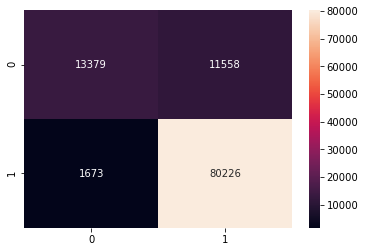

In [43]:
tfidf_rf_hat = cross_val_predict(tfidf_rf_model, X_train, y_train, cv = 5)
cm = confusion_matrix(y_train, tfidf_rf_hat)
f = sns.heatmap(cm, annot=True, fmt = 'g')

Similar results to TF-IDF with NB, both these models are predicting more positive classes than negative.

### Word Embeddings

The previous two vectorization strategies have only focused on term frequency. In order to try to capture semantic meaning of terms, we can use word embeddings. Using Word2Vec we can create word vector embeddings that can try to capture semantic relationships between words, if given enough data to train on.

In [44]:
# creating a w2v model
model = Word2Vec(X_train, size=100, window=5, min_count=1, workers=4)

In [45]:
# total reviews in train set
model.corpus_count

106836

In [46]:
# train model
model.train(X_train, total_examples=model.corpus_count, epochs=10)

(37519958, 44748080)

In [47]:
# get word vectors
wv = model.wv

In [48]:
wv.most_similar('great')

[('good', 0.8044671416282654),
 ('excellent', 0.7877033948898315),
 ('fantastic', 0.7730807065963745),
 ('awesome', 0.7492125034332275),
 ('nice', 0.6824965476989746),
 ('amazing', 0.6690356731414795),
 ('decent', 0.6482011079788208),
 ('wonderful', 0.6363312005996704),
 ('perfect', 0.6274439096450806),
 ('terrific', 0.6216385364532471)]

In [49]:
# Total vocabulary created 
len(wv.index2word)

63198

In [50]:
len(wv.vectors)

63198

In [51]:
# create a dictionary of words and vectors to plug into vectorizer pipeline
w2v = dict(zip(wv.index2word, wv.vectors))

Word vectors with a total vocabulary of 63,198 has been created. Less than previous vectorizers, this may be due to the inclusion of bigrams previously. We can check to see how well model is by checking similar words found by the model.

In [52]:
# testing w2v model by checking simlar word groupings

sample = ['feel', 'good', 'product', 'cheap', 'bad', 'great','price']

# loop through sample list and grab the top 5 most similar words
similar_words = {word: [item[0] for item in wv.most_similar([word], topn=5)]
                  for word in sample}
similar_words


{'feel': ['feeling', 'squeeze', 'material', 'hooksetc', 'plasticy'],
 'good': ['decent', 'great', 'excellent', 'ok', 'fantastic'],
 'product': ['item', 'company', 'products', 'targetwalmartamazon', 'seller'],
 'cheap': ['cheaply', 'expensive', 'cheep', 'inexpensive', 'cheapo'],
 'bad': ['terrible', 'horrible', 'ok', 'good', 'okay'],
 'great': ['good', 'excellent', 'fantastic', 'awesome', 'nice'],
 'price': ['cost', 'dollar', 'thesetheyre', 'pricing', 'consider']}

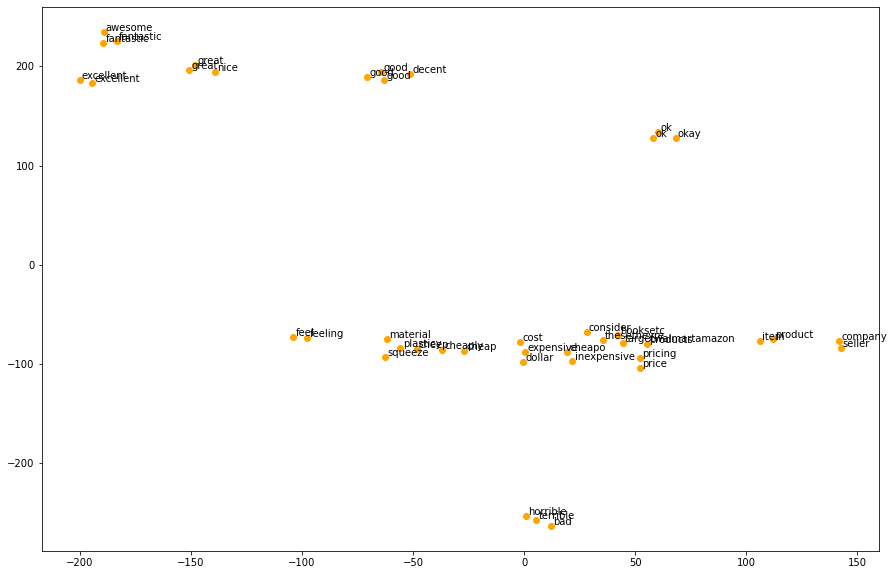

In [53]:
# concatenate sample and similar words
labels = sum([[k] + v for k, v in similar_words.items()], [])

# get vectors of all words
vec = wv[labels]

# reduce dimensionality of vectors to plot them
tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(vec)

fig, ax = plt.subplots(figsize = (15,10))

ax.scatter(T[:, 0], T[:, 1], c='orange')

# label points
for label, x, yt in zip(labels, T[:, 0], T[:, 1]):
    ax.annotate(label, xy=(x+1, yt+1), xytext=(0, 0), textcoords='offset points', fontsize = 10)

Vectors created by w2v looks sensible. Words from our similar words search group together and are distinct from other groupings. Words similar to good are far away from words similar to bad.

#### Mean Word embeddings

To make use of these individual word vectors for classification, we can compute the mean word embedding for each document. Basically we can take all the vectors represented by each word in a document and average them together in one single vector representing the document. This can help reduce dimensionality of features and make algorithms faster to execute.

In [54]:
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(w2v))])
    
    # Note: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # it can't be used in a scikit-learn pipeline  
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

Naive Bayes does not take negative values for input, which some vectors created will have. I will skip MNB() classifer for these next steps to save some time on my part.

#### Logistic Regression with Word2Vec

In [160]:
w2v_logr_model = Pipeline([
    ('w2v', W2vVectorizer(w2v)),
    ('logr', logr)
])

w2v_logr = cross_validate(w2v_logr_model, X_train, y_train, cv = 5, 
                          scoring = ['precision_macro', 'recall_macro', 'f1_macro'])

model_results = model_results.append({'Model': 'w2v_logr_model',
                      'mean f1_score': round(w2v_logr['test_f1_macro'].mean(), 4),
                      'std f1_score': round(w2v_logr['test_f1_macro'].std(), 4),
                      'mean precision': round(w2v_logr['test_precision_macro'].mean(), 4),
                      'mean recall': round(w2v_logr['test_recall_macro'].mean(), 4)}, ignore_index = True)

model_results

,Model,mean f1_score,std f1_score,mean precision,mean recall
0,cv_logr_model,0.8445,0.0026,0.8368,0.8532
1,cv_mnb_model,0.8318,0.0023,0.8216,0.8441
2,cv_rf_model,0.7974,0.0029,0.8771,0.7602
3,tfidf_logr_model,0.8449,0.0037,0.8279,0.8689
4,tfidf_mnb_model,0.7371,0.0018,0.8789,0.6976
5,tfidf_rf_model,0.7965,0.0036,0.8815,0.7580
6,w2v_logr_model,0.7863,0.0023,0.7673,0.8287


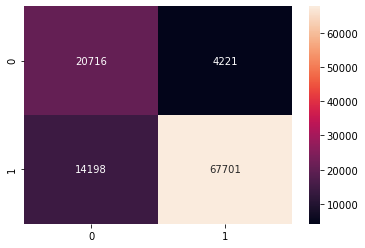

In [56]:
w2v_logr_hat = cross_val_predict(w2v_logr_model, X_train, y_train, cv = 5)
cm = confusion_matrix(y_train, w2v_logr_hat)
f = sns.heatmap(cm, annot=True, fmt = 'g')

Compared to baseline model, w2v with logistic regression placed more emphasis on the negative class. Resulting in a greater amount of false negatives.

#### Random Forest with Word2Vec

In [161]:
w2v_rf_model = Pipeline([
    ('w2v', W2vVectorizer(w2v)),
    ('rf', rf)
])

w2v_rf = cross_validate(w2v_rf_model, X_train, y_train, cv = 5, 
                        scoring = ['precision_macro', 'recall_macro', 'f1_macro'])

model_results = model_results.append({'Model': 'w2v_rf_model',
                      'mean f1_score': round(w2v_rf['test_f1_macro'].mean(), 4),
                      'std f1_score': round(w2v_rf['test_f1_macro'].std(), 4),
                      'mean precision': round(w2v_rf['test_precision_macro'].mean(), 4),
                      'mean recall': round(w2v_rf['test_recall_macro'].mean(), 4)}, ignore_index = True)

model_results

,Model,mean f1_score,std f1_score,mean precision,mean recall
0,cv_logr_model,0.8445,0.0026,0.8368,0.8532
1,cv_mnb_model,0.8318,0.0023,0.8216,0.8441
2,cv_rf_model,0.7974,0.0029,0.8771,0.7602
3,tfidf_logr_model,0.8449,0.0037,0.8279,0.8689
4,tfidf_mnb_model,0.7371,0.0018,0.8789,0.6976
5,tfidf_rf_model,0.7965,0.0036,0.8815,0.7580
6,w2v_logr_model,0.7863,0.0023,0.7673,0.8287
7,w2v_rf_model,0.7279,0.0024,0.8456,0.6923


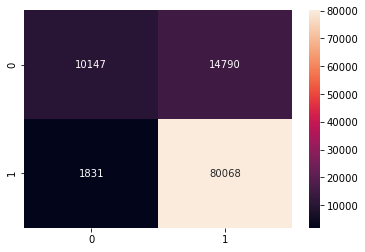

In [59]:
w2v_rf_hat = cross_val_predict(w2v_rf_model, X_train, y_train, cv = 5)
cm = confusion_matrix(y_train, w2v_rf_hat)
f = sns.heatmap(cm, annot=True, fmt = 'g')

This model also performed poorly compared to baseline model. Putting more emphasis on the positive class, resulting in a larger amount of false positives.

#### Pre-trained word vectors with GloVe

Instead of training word embeddings, we can make use of weights from models that have been trained on massive amounts of text data. One popular model is GloVe, which has been trained on text data from wikipedia.

In [60]:
# find total vocabulary of train set
total_vocabulary = set(word for review in X_train for word in review)

In [61]:
len(total_vocabulary)

63198

In [62]:
# get appropriate vectors from GloVe file, using 100 dimension vectors
glove = {}
with open('data/glove.6B.100d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

In [63]:
glove['great']

array([-0.013786 ,  0.38216  ,  0.53236  ,  0.15261  , -0.29694  ,
       -0.20558  , -0.41846  , -0.58437  , -0.77355  , -0.87866  ,
       -0.37858  , -0.18516  , -0.128    , -0.20584  , -0.22925  ,
       -0.42599  ,  0.3725   ,  0.26077  , -1.0702   ,  0.62916  ,
       -0.091469 ,  0.70348  , -0.4973   , -0.77691  ,  0.66045  ,
        0.09465  , -0.44893  ,  0.018917 ,  0.33146  , -0.35022  ,
       -0.35789  ,  0.030313 ,  0.22253  , -0.23236  , -0.19719  ,
       -0.0053125, -0.25848  ,  0.58081  , -0.10705  , -0.17845  ,
       -0.16206  ,  0.087086 ,  0.63029  , -0.76649  ,  0.51619  ,
        0.14073  ,  1.019    , -0.43136  ,  0.46138  , -0.43585  ,
       -0.47568  ,  0.19226  ,  0.36065  ,  0.78987  ,  0.088945 ,
       -2.7814   , -0.15366  ,  0.01015  ,  1.1798   ,  0.15168  ,
       -0.050112 ,  1.2626   , -0.77527  ,  0.36031  ,  0.95761  ,
       -0.11385  ,  0.28035  , -0.02591  ,  0.31246  , -0.15424  ,
        0.3778   , -0.13599  ,  0.2946   , -0.31579  ,  0.4294

In [84]:
len(glove)

26555

Only 26,555 word vectors were found from GloVe. This could be due to the fact that I have not cleaned my text enough. There may be mispelled words or non sensible text as a result from my cleaning process. I will continue testing classifiers with these pre-trained words vectors, however I belive results will not be as great due to lower dimensionality of features.

#### Logistic Regression with GloVe

In [162]:
glove_logr_model = Pipeline([
    ('glove', W2vVectorizer(glove)),
    ('logr', logr)
])

In [163]:
glove_logr = cross_validate(glove_logr_model, X_train, y_train, cv = 5, 
                            scoring = ['precision_macro', 'recall_macro', 'f1_macro'])

model_results = model_results.append({'Model': 'glove_logr_model',
                      'mean f1_score': round(glove_logr['test_f1_macro'].mean(), 4),
                      'std f1_score': round(glove_logr['test_f1_macro'].std(), 4),
                      'mean precision': round(glove_logr['test_precision_macro'].mean(), 4),
                      'mean recall': round(glove_logr['test_recall_macro'].mean(), 4)}, ignore_index = True)

model_results

C:\Users\PC\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\PC\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\PC\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


,Model,mean f1_score,std f1_score,mean precision,mean recall
0,cv_logr_model,0.8445,0.0026,0.8368,0.8532
1,cv_mnb_model,0.8318,0.0023,0.8216,0.8441
2,cv_rf_model,0.7974,0.0029,0.8771,0.7602
3,tfidf_logr_model,0.8449,0.0037,0.8279,0.8689
4,tfidf_mnb_model,0.7371,0.0018,0.8789,0.6976
5,tfidf_rf_model,0.7965,0.0036,0.8815,0.7580
6,w2v_logr_model,0.7863,0.0023,0.7673,0.8287
7,w2v_rf_model,0.7279,0.0024,0.8456,0.6923
8,glove_logr_model,0.7066,0.0016,0.6974,0.7589


C:\Users\PC\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\PC\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\PC\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


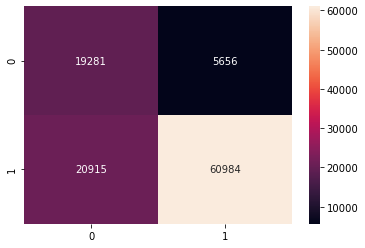

In [69]:
glove_logr_hat = cross_val_predict(glove_logr_model, X_train, y_train, cv = 5)
cm = confusion_matrix(y_train, glove_logr_hat)
f = sns.heatmap(cm, annot=True, fmt = 'g')

As expected results are much lower compared to baseline model. This model placed a heavy emphasis on the negative class.

#### Random Forest with GloVe

In [164]:
glove_rf_model = Pipeline([
    ('glove',  W2vVectorizer(glove)),
    ('rf', rf)
])

glove_rf = cross_validate(glove_rf_model, X_train, y_train, cv = 5, 
                          scoring = ['precision_macro', 'recall_macro', 'f1_macro'])



model_results = model_results.append({'Model': 'glove_rf_model',
                      'mean f1_score': round(glove_rf['test_f1_macro'].mean(), 4),
                      'std f1_score': round(glove_rf['test_f1_macro'].std(), 4),
                      'mean precision': round(glove_rf['test_precision_macro'].mean(), 4),
                      'mean recall': round(glove_rf['test_recall_macro'].mean(), 4)}, ignore_index = True)

model_results

,Model,mean f1_score,std f1_score,mean precision,mean recall
0,cv_logr_model,0.8445,0.0026,0.8368,0.8532
1,cv_mnb_model,0.8318,0.0023,0.8216,0.8441
2,cv_rf_model,0.7974,0.0029,0.8771,0.7602
3,tfidf_logr_model,0.8449,0.0037,0.8279,0.8689
4,tfidf_mnb_model,0.7371,0.0018,0.8789,0.6976
5,tfidf_rf_model,0.7965,0.0036,0.8815,0.7580
6,w2v_logr_model,0.7863,0.0023,0.7673,0.8287
7,w2v_rf_model,0.7279,0.0024,0.8456,0.6923
8,glove_logr_model,0.7066,0.0016,0.6974,0.7589
9,glove_rf_model,0.6280,0.0010,0.8136,0.6107


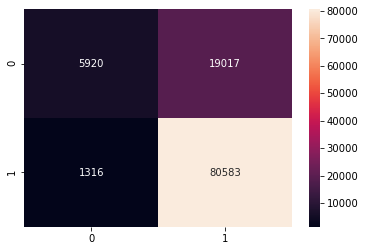

In [71]:
glove_rf_hat = cross_val_predict(glove_rf_model, X_train, y_train, cv = 5)
cm = confusion_matrix(y_train, glove_rf_hat)
f = sns.heatmap(cm, annot=True, fmt = 'g')

As expected again this model performed poorly compared to baseline. But this version placed more emphasis on the positive class compared to logistic regression with glove.

## Evaluating Final Model

Best model based on f1 score was found to be TF-IDF vectorizer with logistic regression.

In [66]:
tfidf_logr_model.fit(X_train, y_train)

Pipeline(steps=[('tfidfvec',
                 TfidfVectorizer(min_df=10, ngram_range=(1, 2),
                                 preprocessor=<function dummy at 0x00000221310B5C10>,
                                 tokenizer=<function dummy at 0x00000221310B5C10>)),
                ('logreg',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    solver='saga'))])

In [67]:
y_pred = tfidf_logr_model.predict(X_test)

In [167]:
print('f1: ' + str(f1_score(y_test, y_pred, average = 'macro')))
print('precision: ' + str(precision_score(y_test, y_pred, average = 'macro')))
print('recall: ' + str(recall_score(y_test, y_pred, average = 'macro')))

f1: 0.8511681738038521
precision: 0.8331699203967295
recall: 0.8772236175123104


In [168]:
model_results[model_results.Model == 'tfidf_logr_model']

,Model,mean f1_score,std f1_score,mean precision,mean recall
3,tfidf_logr_model,0.8449,0.0037,0.8279,0.8689


f1, precision, and recall scores are similar to our cross validation scores. This is a good sign that our model is not over fitting on the training data.

### Visualizing Important features

For logistic regression, a simple way to infer feature importance of the model would be to examine the coefficients assigned to each feature. Since this was modeled as a binary classification problem with negative being 0 and 1 being positive sentiment, positive scores indicate features that predicts class 1 and negative scores indicate features that predict class 0. We can then look for the highest positive and lowest negative features to find the top important words in each sentiment.

In [216]:
# grab coef from model
weights = tfidf_logr_model.steps[1][1].coef_[0]
weights

array([ 0.36692923,  0.06541785,  0.27658282, ..., -0.33115839,
       -0.48785543,  0.23740212])

In [174]:
# grab feature names
features = tfidf_logr_model['tfidfvec'].get_feature_names()

In [176]:
# concat them to a dataframe
feature_importance = pd.DataFrame({'words': features, 'weights': weights})

In [217]:
# top positive features
top_pos = feature_importance.sort_values('weights', ascending = False).head(25)

In [218]:
# bottom negative features
top_neg = feature_importance.sort_values('weights', ascending = True).head(25)

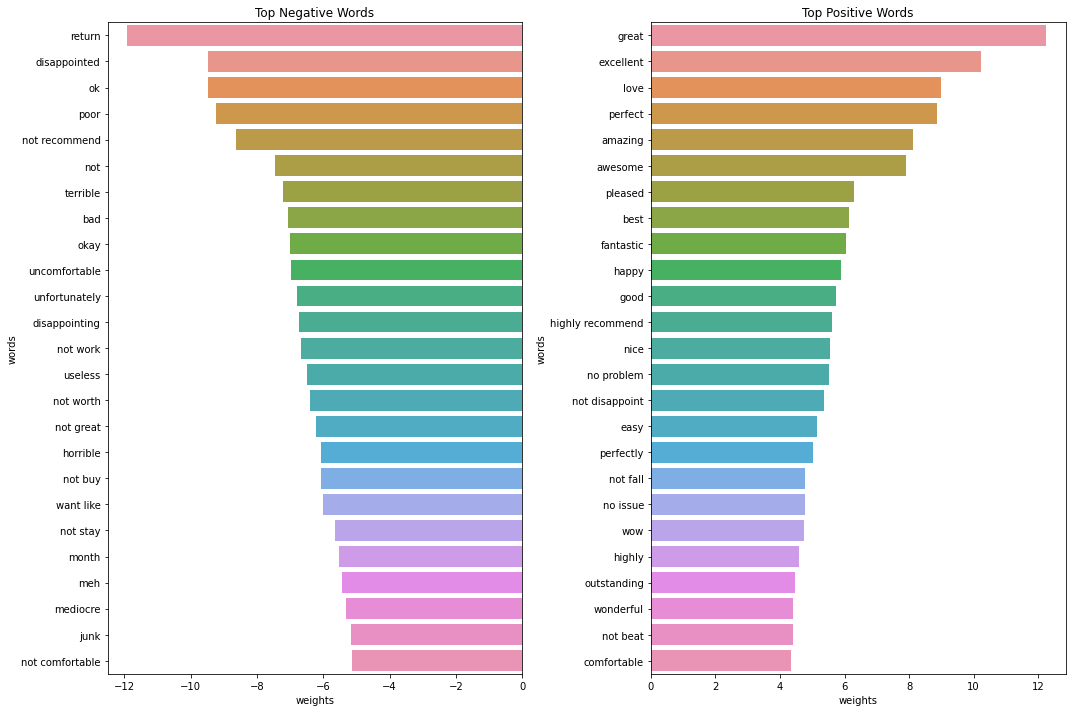

In [219]:
fig, axs = plt.subplots(1,2, figsize=(15,10))

sns.barplot(data = top_neg, x = 'weights', y = 'words', orient = 'h', ax = axs[0])
sns.barplot(data = top_pos, x = 'weights', y = 'words', orient = 'h', ax = axs[1])

axs[0].set_title('Top Negative Words')
axs[1].set_title('Top Positive Words')

fig.tight_layout();

Top positive words show general satisfaction from the reviews. Top Negative words show dissatisfaction, with the most negative score associated with the word return. Which indicates that customers generally dissatisfied with the product would want a refund instead of continuing use.

## Conclusion

Analyzing product reviews can help get a better sense of the market. Based on my this project we are able to identify meaningful insights of what customers think about certain products. Reviews related to comfort and sound quality make up around 60% of the total reviews in this data. 

Comfort, the topic with the most reviews, also has the highest percent of negative reviews. Which makes sense as people come in all different sizes and shapes, it is very difficult for any one product to fit comfortably on everyone.

Interstingly the second most popular topic, sound quality, has the highest percent of positive reviews. 

Through this project I was able to confirm that products with higher ratings generally have a higher positive sentiment and  products with lower ratings generally have a negative sentiment. 

## Recommendations

* <b>Focus on customizable comfort</b> - Comfort was found to be the most popular topic disscussed in product reviews, it also contained the highest percent of negative reviews with one of the top negatively associated word found to be uncomfortable. Providing changable earbud plugs or head phone cushions can help improve comfort of product no matter the customer.

* <b>Improve Customer service</b> - The second highest percent of negative reviews was found to be associated with customer service. A few of the top terms associated with the topic were "send replacement", "warranty", "feedback", "update review". Addressing specific issues raised by customers or making broader changes can improve overall satisfaction.

* <b>Adjust Marketing Strategies</b> - Battery / Connectivity was found to have higher negative sentiment compared to design or sound quality. Focusing on marketing products with longer battery life or more stable bluetooth connections can help address customers that feel negatively towards this topic.

## Limitations

Due to the nature of Amazon reviews, they are unable to be an exact representation of the overall market:

* Companies may offer discounts or free product for high reviews or there can be a high amount of fake reviews generated by algorithms.

* Only the most vocal will be heard, there are many customers that will like or dislike a product but not leave reviews.

Other limitations deal with my processing of text data.

* Best model was found to be TF-IDF vectorizer with logistic regression, however this method only focuses on term frequency. It is unable to capture semantic relationship between words.

* My text cleaning methods did not address words with typos or nonsensical words, with may lead to increased feature dimensionaltiy during training and effect results.

## Next Steps

* Try different methods for topic modeling, such as Top2Vec. LDA works by assuming that each document is generated by a random process involving the selection of topics and words from those topics. Top2Vec, on the other hand, is a neural network-based method that clusters similar documents and identifies representative topics, which can help to better capture semantic relationships between words.

* Make use of recurrent neual network with LSTM for classification. 

* Try aspect based sentiment analysis.